In [1]:
from asyncore import close_all
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
import backtrader as bt
from statsmodels.tsa.stattools import coint, adfuller
import quantstats as qs
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    
    # Find the stocks return matrix
    R = data.diff()

    # Delete the first row of NaN values
    R = R.iloc[1:, :]

    # Standardize the returns
    Y = (R - R.mean()) / R.std()

    # Get covariance and correlation matrix of standardized returns
    Covariance = Y.cov()
    Correlation = Y.corr()

    # Plot the returns matrix to see they're roughly on the same scale
    plt.plot(Y)
    plt.show()

    # Confirm that we have stationary time series
    adf = -100
    for i in range(1, 11):
        x = adfuller(Y.iloc[:, 10].dropna())
        adf = max(x[0], adf)
    print("Max ADF critical value - ", adf)

    # Find the eigenvalues and eigenvectors
    eig_vals,eig_vecs = np.linalg.eig(Covariance)

    # Sort eigenvalues and eigenvectors in decreasing order
    idx = eig_vals.argsort()[::-1]   
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:,idx]

    print(eig_vals)

    xl = []
    yl = []
    k1 = -3
    k2 = -4



    #set up the labels so that central points are blank
    tickers = list(Y.columns)

    #insert some spacers as we want pairs of labels
    for index, item in enumerate(tickers):
        if index % 2 == 0:
            tickers.insert(index,'')


    #build up data points for loadings plot
    for i in range(eig_vecs.shape[0]):

        x_val = [0,eig_vecs[i,k1]*(0 if eig_vals[i]<0 else np.sqrt(eig_vals[i]))]
        y_val = [0,eig_vecs[i,k2]*(0 if eig_vals[i]<0 else np.sqrt(eig_vals[i]))]
        xl.append(x_val)
        yl.append(y_val)

    #convert list of lists to list     
    flattenedx = [val for sublist in xl for val in sublist]
    flattenedy = [val for sublist in yl for val in sublist]

    # print(flattenedx)
    # print(flattenedy)

    #list to contain tuples (ith example, quandrant location 1,2,3,4)
    quad = []

    for i in range(eig_vecs.shape[0]):
        x = eig_vecs[i,k1]*(0 if eig_vals[i]<0 else np.sqrt(eig_vals[i]))
        y = eig_vecs[i,k2]*(0 if eig_vals[i]<0 else np.sqrt(eig_vals[i]))
        
        #calculate the location of each indicies wrt the quadrant of the loading plot
        if((x > 0) and (y > 0)):
            quad.append((i, 1))
        elif((x < 0) and (y > 0)):
            quad.append((i, 2))
        elif((x < 0) and (y < 0)):
            quad.append((i, 3))
        elif((x > 0) and (y < 0)):
            quad.append((i, 4))


    #reset the tickers to the original format
    tickers = list(Y.columns)

    #collect the entities for ranking later
    corrells = pd.DataFrame(columns=["Stock/index_A","Stock/index_B","R^2"])

    #select the stocks only
    stocks = tickers[:10]

    #calculate quadrant membership and determine opposing pairs
    for i in range(len(quad)):
        # Q1 vs Q3
        if(quad[i][1] == 1):
            for j in range(len(quad)):
                #we are only interested in correlations that involve at least 1 stock
                if(quad[j][1] == 3 and ((tickers[quad[i][0]] in stocks) or (tickers[quad[j][0]] in stocks)) ):

                    ts1 = Y[tickers[quad[i][0]]]  # time-series for cross plots
                    ts2 = Y[tickers[quad[j][0]]]
    
                    # correlation metrics 
                    slope, intercept, r2, pvalue, _ = stats.linregress(ts1, ts2)
            
                    corrells = corrells.append({"Stock/index_A":tickers[quad[i][0]],"Stock/index_B":tickers[quad[j][0]],"R^2":r2},ignore_index=True)
                    
                        
                        
        # Q2 vs Q4
        if(quad[i][1] == 2):
            for j in range(len(quad)):
                if(quad[j][1] == 4 and ((tickers[quad[i][0]] in stocks) or (tickers[quad[j][0]] in stocks))):
                
                    ts1 = Y[tickers[quad[i][0]]]  # time-series for cross plots
                    ts2 = Y[tickers[quad[j][0]]]
    
                    # correlation metrics 
                    slope, intercept, r2, pvalue, _ = stats.linregress(ts1, ts2)

                    corrells = corrells.append({"Stock/index_A":tickers[quad[i][0]],"Stock/index_B":tickers[quad[j][0]],"R^2":r2},ignore_index=True)

    corrells = corrells.sort_values(by="R^2",ascending=False)
    corrells = corrells.reset_index(drop=True)
    
    
    # corrells.head(3)
    pairs = []
    for i in range(15):
        # if(i > 0 and corrells['R^2'].values[i] < 0.6):
        #     break
        pairs.append((corrells['Stock/index_A'].values[i], corrells['Stock/index_B'].values[i], corrells['R^2'].values[i]))

    return pairs

In [3]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [4]:
# To get pairs with no common stocks
def get_distinct_pairs(pairs):
    pairs_used = dict()
    ans = []

    for pair in pairs:
        if (pairs_used.get(pair[0], 0) + pairs_used.get(pair[1], 0) == 0):
            ans.append(pair)
            pairs_used[pair[0]] = 1
            pairs_used[pair[1]] = 1
    
    return ans

In [5]:
class PairsTrading(bt.Strategy):
    
    def __init__(self):
        self.current_position = dict()

        # Number of stock pairs
        self.num = len(self.datas) // 3

        self.zmean = [0] * self.num
        self.zstddev = [0] * self.num
        self.status = [0] * self.num

        # Calculating % of portfolio to invest in each stock
        self.pstock = 0.5 / self.num
        
        for i in range(self.num):

            # Pair  0   1   2   x
            # Ratio 2   5   8   3x+2
            # Buflen gives length of the data
            self.len = self.datas[3 * i + 2].close.buflen()

            # Calculating mean
            cnt = 0
            sum = 0
            for j in range(self.len):
                sum += self.datas[3 * i + 2].close[j]
                cnt += 1
            self.zmean[i] = sum / cnt

            # Calculating stddev
            sum = 0
            for j in range(self.len):
                sum += (self.datas[3 * i + 2].close[j] - self.zmean[i]) * (self.datas[3 * i + 2].close[j] - self.zmean[i])
            self.zstddev[i] = np.sqrt(sum / cnt)
        
         
        for data in self.datas:
            self.current_position[data._name] = False
        
    
    def next(self):

        # Data is in the form Pair0StockA,Pair0StockB,Pair0Zscore, Pair1StockA,Pair1StockB....
        # Pairs     0       1       2       i
        # Data used 0,1,2   3,4,5   6,7,8   3i, 3i+1,3i+2
        
        for i in range(self.num):
            position1 = self.current_position[self.datas[3 * i]._name]
            position2 = self.current_position[self.datas[3 * i + 1]._name]

            zlow = self.zmean[i] - self.zstddev[i]
            zup = self.zmean[i] + self.zstddev[i]
        
            if (self.datas[3 * i + 2].close < zlow) and (self.status[i] != 1):
                
                self.status[i] = 1

                if position2:
                    # Selling asset2
                    self.close(data = self.datas[3 * i + 1])
                    self.current_position[self.datas[3 * i + 1]._name] = False

                if not position1:
                    # Buying asset1
                    self.order_target_percent(data=self.datas[3 * i], target = self.pstock)
                    self.current_position[self.datas[3 * i]._name] = True

            
            elif (self.datas[3 * i + 2].close > zup) and (self.status != -1):
                
                self.status[i] = -1
                
                if position1:
                    # Selling asset1
                    self.close(data = self.datas[3 * i])
                    self.current_position[self.datas[3 * i]._name] = False

                if not position2:
                    # Buying asset2
                    self.order_target_percent(data=self.datas[3 * i + 1], target = self.pstock)
                    self.current_position[self.datas[3 * i + 1]._name] = True
            
            elif (self.datas[3 * i + 2].close < zup) and (self.datas[3 * i + 2].close > zlow):

                if self.status[i] == -1:
                
                    if not position1:
                        self.order_target_percent(data=self.datas[3 * i], target = self.pstock)
                        self.current_position[self.datas[3 * i]._name] = True

                    if position2:
                        self.close(data = self.datas[3 * i + 1])
                        self.current_position[self.datas[3 * i + 1]._name] = False

                if self.status[i] == 1:

                    if not position2:
                        self.order_target_percent(data=self.datas[3 * i + 1], target = self.pstock)
                        self.current_position[self.datas[3 * i + 1]._name] = True

                    if position1:
                        self.close(data = self.datas[3 * i])
                        self.current_position[self.datas[3 * i]._name] = False
                
                self.status[i] = 0

    def stop(self):

        for i in range(self.num):
            self.close(data = self.datas[3 * i])
            self.close(data = self.datas[3 * i + 1])

Starting Portfolio value is 200000
Train period: 2010 to 2011
Test year: 2012


c:\Users\ldrub\anaconda3\envs\backtrader\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


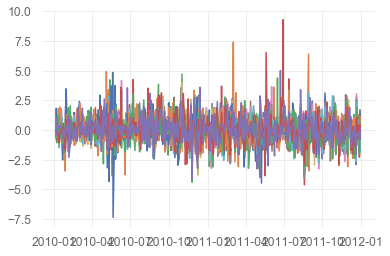

Max ADF critical value -  -5.385265005783258
[6.04457145 1.08346895 0.98456399 0.89466881 0.84583342 0.77289978
 0.73786749 0.64456229 0.60754408 0.52458273 0.41807879 0.41460153
 0.40411123 0.33640819 0.28623726]
Number of pairs: 5

Transactions:
  - 2012-01-03 00:00:00: [516, 39.314674377441406, 0, 'BAJFINANCE', -20286.371978759766], [223, 93.8899917602539, 7, 'SBIN', -20937.46816253662], [92, 231.0024719238281, 9, 'INDUSINDBK', -21252.227416992184]
  - 2012-01-04 00:00:00: [47, 406.8647766113281, 3, 'BAJAJFINSV', -19122.644500732422]
  - 2012-01-19 00:00:00: [-516, 43.68257141113281, 0, 'BAJFINANCE', 22540.20684814453], [91, 234.9044342041016, 1, 'KOTAKBANK', -21376.303512573246]
  - 2012-01-20 00:00:00: [480, 43.92313003540039, 0, 'BAJFINANCE', -21083.102416992188], [-91, 244.80972290039065, 1, 'KOTAKBANK', 22277.68478393555]
  - 2012-01-24 00:00:00: [-480, 46.2353401184082, 0, 'BAJFINANCE', 22192.963256835938], [89, 245.5526733398437, 1, 'KOTAKBANK', -21854.18792724609]
  - 2012-0

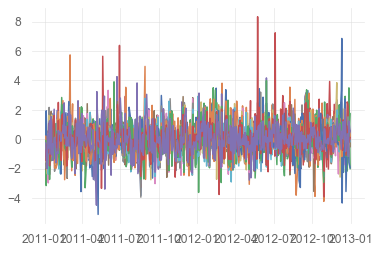

Max ADF critical value -  -21.521757089093565
[6.2985239  1.10798748 0.97712631 0.88414566 0.86392348 0.79197177
 0.70270248 0.59477642 0.55454783 0.49565462 0.41655917 0.40351979
 0.36688921 0.28976526 0.25190662]
Number of pairs: 4

Transactions:
  - 2013-01-02 00:00:00: [223, 149.8707275390625, 0, 'ICICIBANK', -33421.17224121094], [326, 100.05184173583984, 6, 'BAJFINANCE', -32616.90040588379], [102, 325.9913635253906, 7, 'KOTAKBANK', -33251.119079589844]
  - 2013-01-09 00:00:00: [107, 306.0998229980469, 4, 'HDFCBANK', -32752.681060791016]
  - 2013-01-25 00:00:00: [48, 696.34033203125, 3, 'SRTRANSFIN', -33424.3359375], [-107, 304.9762878417969, 4, 'HDFCBANK', 32632.462799072266]
  - 2013-01-28 00:00:00: [-48, 706.6652221679688, 3, 'SRTRANSFIN', 33919.9306640625], [108, 307.40679931640625, 4, 'HDFCBANK', -33199.934326171875]
  - 2013-01-29 00:00:00: [-223, 153.3427276611328, 0, 'ICICIBANK', 34195.42826843262], [39, 826.1572875976562, 1, 'BAJAJFINSV', -32220.134216308594]
  - 2013-02-0

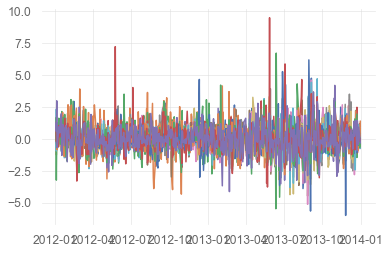

Max ADF critical value -  -9.128680351986947
[6.33410508 1.18661418 1.06412516 0.95747339 0.84687649 0.78910931
 0.68982272 0.57692412 0.48874065 0.46542172 0.43772104 0.37067755
 0.32469783 0.28493073 0.18276003]
Number of pairs: 4

Transactions:
  - 2014-01-02 00:00:00: [247, 144.59619140625, 6, 'SBIN', -35715.25927734375], [151, 234.6062774658203, 7, 'AXISBANK', -35425.54789733887]
  - 2014-01-20 00:00:00: [814, 42.91465759277344, 3, 'PFC', -34932.53128051758]
  - 2014-02-05 00:00:00: [-814, 43.54290008544922, 3, 'PFC', 35443.920669555664], [276, 126.60526275634766, 4, 'BAJFINANCE', -34943.05252075195]
  - 2014-02-21 00:00:00: [91, 401.50201416015625, 0, 'PEL', -36536.68328857422]
  - 2014-02-24 00:00:00: [-91, 394.50439453125, 0, 'PEL', 35899.89990234375], [114, 312.8887023925781, 1, 'HDFCBANK', -35669.312072753906]
  - 2014-02-26 00:00:00: [91, 387.958251953125, 0, 'PEL', -35304.200927734375], [-114, 315.8730163574219, 1, 'HDFCBANK', 36009.523864746094]
  - 2014-03-03 00:00:00: [-

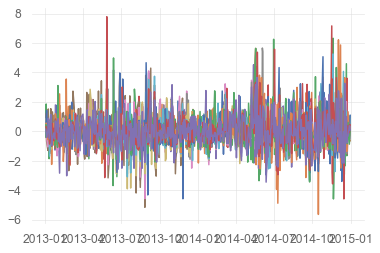

Max ADF critical value -  -23.486851339746757
[5.85389049 1.31056141 1.16396144 0.93164154 0.8669417  0.83039416
 0.73701015 0.58072828 0.53614139 0.50229862 0.40504902 0.37500228
 0.35286929 0.31743132 0.23607891]
Number of pairs: 5

Transactions:
  - 2015-01-02 00:00:00: [30, 1271.0042724609375, 0, 'BAJAJFINSV', -38130.128173828125], [119, 317.9662475585937, 3, 'BAJFINANCE', -37837.98345947265], [85, 457.8008728027344, 5, 'HDFCBANK', -38913.07418823242], [48, 791.9300537109375, 7, 'INDUSINDBK', -38012.642578125], [78, 499.9318542480469, 10, 'AXISBANK', -38994.684631347656]
  - 2015-01-28 00:00:00: [-119, 399.11175537109375, 3, 'BAJFINANCE', 47494.298889160156], [427, 99.15634155273438, 4, 'PFC', -42339.75784301758], [-85, 501.9305725097656, 5, 'HDFCBANK', 42664.09866333008], [39, 1090.255126953125, 6, 'SRTRANSFIN', -42519.949951171875]
  - 2015-01-29 00:00:00: [-30, 1454.9320068359375, 0, 'BAJAJFINSV', 43647.960205078125], [61, 663.23388671875, 1, 'KOTAKBANK', -40457.26708984375], [8

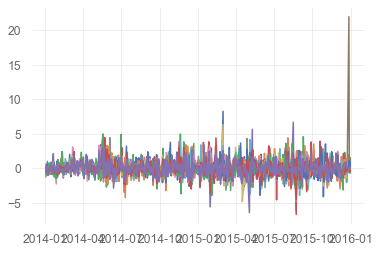

Max ADF critical value -  -11.684510839406636
[5.53940175 1.23107241 1.09181892 1.0557454  0.91282577 0.84896852
 0.7651093  0.69777867 0.64374345 0.54059503 0.43325334 0.39904389
 0.28834987 0.2843157  0.26797799]
Number of pairs: 5

Transactions:
  - 2016-01-04 00:00:00: [26, 1544.52685546875, 1, 'BAJAJHLDNG', -40157.6982421875], [44, 894.732421875, 4, 'PEL', -39368.2265625], [20, 1954.3077392578125, 5, 'BAJAJFINSV', -39086.15478515625], [70, 578.76611328125, 8, 'BAJFINANCE', -40513.6279296875], [78, 515.3825073242189, 10, 'HDFCBANK', -40199.83557128907]
  - 2016-01-05 00:00:00: [187, 219.946533203125, 0, 'ICICIBANK', -41130.001708984375], [-26, 1537.502685546875, 1, 'BAJAJHLDNG', 39975.06982421875], [363, 110.5999984741211, 9, 'PNB', -40147.79944610596], [-78, 511.4828186035156, 10, 'HDFCBANK', 39895.65985107422]
  - 2016-01-11 00:00:00: [-20, 1938.25048828125, 5, 'BAJAJFINSV', 38765.009765625], [199, 199.84410095214844, 6, 'SBIN', -39768.97608947754], [100, 408.8056640625, 7, 'AXIS

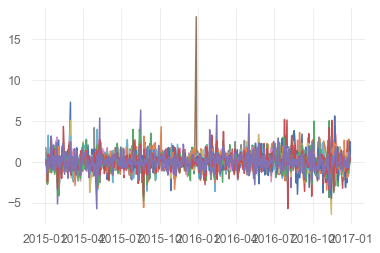

Max ADF critical value -  -19.63632621182909
[5.54369032 1.58727435 1.16522317 0.92564257 0.85539279 0.80245528
 0.79214243 0.64800547 0.5874489  0.46978846 0.44623483 0.39089195
 0.30955877 0.27095869 0.20529203]
Number of pairs: 6

Transactions:
  - 2017-01-03 00:00:00: [14, 3011.82861328125, 3, 'BAJAJFINSV', -42165.6005859375], [48, 876.6566162109375, 6, 'BAJFINANCE', -42079.517578125]
  - 2017-01-18 00:00:00: [164, 256.0345458984375, 12, 'SBIN', -41989.66552734375]
  - 2017-01-20 00:00:00: [69, 605.0812377929688, 8, 'HDFCBANK', -41750.605407714844], [87, 445.810791015625, 11, 'AXISBANK', -38785.538818359375], [-164, 248.7999725341797, 12, 'SBIN', 40803.19549560547]
  - 2017-01-23 00:00:00: [325, 129.75, 7, 'PNB', -42168.75], [-69, 609.1434326171875, 8, 'HDFCBANK', 42030.89685058594]
  - 2017-01-25 00:00:00: [185, 227.78335571289065, 10, 'ICICIBANK', -42139.92080688477]
  - 2017-01-31 00:00:00: [-325, 135.55000305175778, 7, 'PNB', 44053.75099182128], [68, 629.6986083984375, 8, 'HDFC

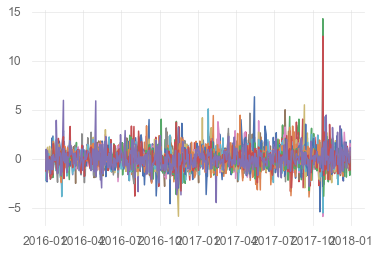

Max ADF critical value -  -19.571562095650975
[4.43962847 2.66629644 1.26291034 0.90457421 0.88122126 0.77586098
 0.69778577 0.6625731  0.56454335 0.51810035 0.4685277  0.40472356
 0.37852682 0.23086454 0.14386312]
Number of pairs: 6

Transactions:
  - 2018-01-02 00:00:00: [31, 1621.561279296875, 0, 'HDFC', -50268.399658203125], [29, 1714.7373046875, 7, 'BAJFINANCE', -49727.3818359375], [51, 1002.1480102539062, 9, 'KOTAKBANK', -51109.54852294922]
  - 2018-01-03 00:00:00: [91, 559.7548217773439, 4, 'AXISBANK', -50937.68878173829]
  - 2018-01-15 00:00:00: [-31, 1781.4564208984375, 0, 'HDFC', 55225.14904785156], [18, 2713.42529296875, 1, 'BAJAJHLDNG', -48841.6552734375]
  - 2018-01-17 00:00:00: [19, 2650.10205078125, 3, 'PEL', -50351.93896484375], [-91, 584.47412109375, 4, 'AXISBANK', 53187.14501953125]
  - 2018-01-22 00:00:00: [28, 1782.218017578125, 0, 'HDFC', -49902.1044921875], [-18, 2705.648681640625, 1, 'BAJAJHLDNG', 48701.67626953125]
  - 2018-01-30 00:00:00: [-28, 1844.57666015625

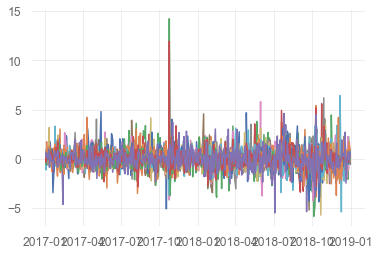

Max ADF critical value -  -9.766743251464785
[4.48781559 2.66948476 1.2349286  0.9360087  0.85094413 0.75766277
 0.67461739 0.66324437 0.57249665 0.54918589 0.44760148 0.42498387
 0.29366568 0.23140713 0.20595299]
Number of pairs: 5

Transactions:
  - 2019-01-02 00:00:00: [63, 1055.327392578125, 5, 'HDFCBANK', -66485.62573242188], [34, 1904.9364013671875, 8, 'HDFC', -64767.837646484375], [186, 362.8275146484375, 10, 'ICICIBANK', -67485.91772460938]
  - 2019-01-03 00:00:00: [30, 2179.494140625, 7, 'PEL', -65384.82421875], [-34, 1862.8106689453125, 8, 'HDFC', 63335.562744140625]
  - 2019-01-07 00:00:00: [-30, 2172.775634765625, 7, 'PEL', 65183.26904296875], [35, 1897.4827880859373, 8, 'HDFC', -66411.8975830078]
  - 2019-01-08 00:00:00: [31, 2200.41943359375, 7, 'PEL', -68213.00244140625], [-35, 1884.06591796875, 8, 'HDFC', 65942.30712890625]
  - 2019-01-09 00:00:00: [23, 2889.8994140625, 3, 'BAJAJHLDNG', -66467.6865234375]
  - 2019-01-11 00:00:00: [-23, 2944.932861328125, 3, 'BAJAJHLDNG'

c:\Users\ldrub\anaconda3\envs\backtrader\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\ldrub\anaconda3\envs\backtrader\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\ldrub\anaconda3\envs\backtrader\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\Users\ldrub\anaconda3\envs\backtrader\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for mu

In [6]:
#read metadata csv
nifty_meta = pd.read_csv(r'pairs_nifty_meta.csv')

# get the ticker list with industry is equal to FINANCIAL SERVICES
tickers = list(nifty_meta[nifty_meta.Industry == 'FINANCIAL SERVICES'].Symbol)

# start and end dates for backtesting
fromdate = datetime.datetime(2010, 1, 1)
todate = datetime.datetime(2020, 6, 15)

# read back the pricing data
prices = pd.read_csv(r'pairs_prices.csv', index_col=['ticker','date'], parse_dates=True)


idx = pd.IndexSlice
# remove tickers where we have less than 10 years of data.
min_obs = 2520
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index
prices = prices.loc[idx[keep,:], :]

# final tickers list
TICKERS = list(prices.index.get_level_values('ticker').unique())


# unstack and take close price
close = prices.unstack('ticker')['close'].sort_index()
close = close.dropna()

# print(close.first('1Y'))

STARTING_PORTFOLIO_VALUE = 200_000
portfolio_val = STARTING_PORTFOLIO_VALUE
print(f'Starting Portfolio value is {portfolio_val}')

# Starting year
year1 = 2010

# To store results of each year
returns_main = pd.Series()

for i in range(10, 2, -1):


    train_size = close.first('2Y').shape[0]  # Train size = Rows of first two years

    # Start period and end period for train and test close
    print(f'Train period: {year1} to {year1 + 1}')
    print(f'Test year: {year1 + 2}')
    
    # Train test split
    train_close, test_close = train_test_split(close.first('3Y'), train_size= train_size, shuffle=False)


    # calculate p-values
    pairs = find_cointegrated_pairs(train_close)
    pairs = sorted(pairs, key = lambda x: x[2])
    
    # No two pairs have a common stock
    pairs = get_distinct_pairs(pairs)
    
    # Number of pairs we get for the present year
    print(f'Number of pairs: {len(pairs)}')
    print()

    cerebro = bt.Cerebro()
    
    for pair in pairs:

        df1 = pd.DataFrame()
        df1['close'] = test_close[pair[0]]
        df2 = pd.DataFrame()
        df2['close'] = test_close[pair[1]]

        # Every 3rd data is the zscore of the ratio of closing prices of the previous two datas
        df3 = pd.DataFrame()
        df3['close'] = zscore(test_close[pair[0]] / test_close[pair[1]])

        data1 = bt.feeds.PandasData(
            dataname = df1,
            datetime = None,
            open = 0,
            close = 0,
            high = 0,
            low = 0,
            volume = None,
            openinterest = None
        )

        data2 = bt.feeds.PandasData(
            dataname = df2,
            datetime = None,
            open = 0,
            close = 0,
            high = 0,
            low = 0,
            volume = None,
            openinterest = None 
        )

        data3 = bt.feeds.PandasData(
            dataname = df3,
            datetime = None,
            open = 0,
            close = 0,
            high = 0,
            low = 0,
            volume = None,
            openinterest = None 
        )

        cerebro.adddata(data1, name = pair[0])
        cerebro.adddata(data2, name = pair[1])
        cerebro.adddata(data3, name = 'Pair')


    
    cerebro.broker.set_cash(portfolio_val)
    cerebro.addstrategy(PairsTrading)
    cerebro.addanalyzer(bt.analyzers.Transactions, _name = "trans")
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

    result = cerebro.run()

    # Pyfolio Functions
    portfolio_stats = result[0].analyzers.getbyname('PyFolio')
    returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
    returns.index = returns.index.tz_convert(None)
    returns_main = returns.append(returns_main)

    #Terminal Outputs
    result[0].analyzers.getbyname('trans').print()


    # Preparation for next year
    portfolio_val = round(cerebro.broker.getvalue(), 2)
    close = close.last(f'{i}Y')     # Removing the first one year of data
    year1 += 1

print(f'Ending Portfolio value is {round(cerebro.broker.getvalue(), 2)}')

# Perfomance Stats are saved in a html output
returns_main.sort_index(inplace = True)
qs.reports.html(returns_main, output='Pair_Stats.html', title='Pairs Trading')